In [ ]:
#### pascal data set using for multi labelling

from fastai.vision.all import *

path = untar_data(URLs.PASCAL_2007)

In [ ]:
path

Path('/root/.fastai/data/pascal_2007')

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
df["labels"]

,labels
0,chair
1,car
2,horse person
3,car
4,bicycle
...,...
5006,horse person
5007,boat
5008,person bicycle
5009,car


In [ ]:
len(np.unique(df["labels"]))

473

In [ ]:
df.shape

(5011, 3)

In [ ]:
df.iloc[:, 0]

,fname
0,000005.jpg
1,000007.jpg
2,000009.jpg
3,000012.jpg
4,000016.jpg
...,...
5006,009954.jpg
5007,009955.jpg
5008,009958.jpg
5009,009959.jpg


In [ ]:
dblock = DataBlock()

In [ ]:
dset = dblock.datasets(df)

In [ ]:
dset.train[0]

(fname       005685.jpg
 labels           train
 is_valid          True
 Name: 2853, dtype: object,
 fname       005685.jpg
 labels           train
 is_valid          True
 Name: 2853, dtype: object)

In [ ]:
dblock = DataBlock(get_x=lambda r: r["fname"], get_y = lambda r: r["labels"])
dset = dblock.datasets(df)
dset.train[0]

('009637.jpg', 'train')

In [ ]:
path_image = dset.train[0][0]
path_image

'009637.jpg'

In [ ]:
path_specific_img = Path(str(path)+"/"+"train/"+ path_image)
path_specific_img

Path('/root/.fastai/data/pascal_2007/train/009637.jpg')

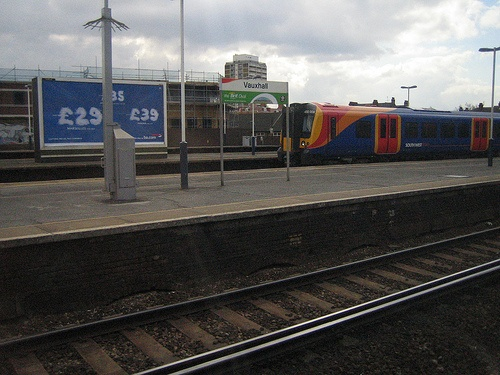

In [ ]:
from PIL import Image

img = Image.open(path_specific_img)
img

In [ ]:
### as the lambda functions are not compatible with the serialization so we should define them as function s

def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(get_x = get_x, get_y=get_y)
dset = dblock.datasets(df)
dset.train[1]

(Path('/root/.fastai/data/pascal_2007/train/007923.jpg'), ['chair', 'sofa'])

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
 get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
                      0., 0., 0., 0., 1.]))

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['person','tvmonitor']

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()  # Rows where 'is_valid' is False
    valid = df.index[df['is_valid']].tolist()   # Rows where 'is_valid' is True
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
 splitter=splitter,
 get_x=get_x,
 get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [ ]:
### ensure that every image is in the same size
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

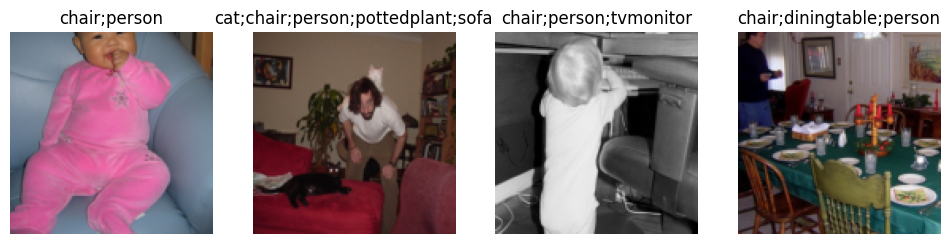

In [ ]:
dls.show_batch(nrows=1, ncols=4)

In [ ]:
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [ ]:
activs[0]

TensorImage([-2.2418, -2.3357,  1.5918, -0.1878,  0.1450, -0.5278,  0.0669,
              0.8720, -0.0889, -0.3722,  0.1785, -1.4691,  2.0758,  0.0589,
              0.0144,  0.4990, -0.8261, -0.5055,  0.2179,  2.5189],
            grad_fn=<AliasBackward0>)

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [ ]:
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
loss = loss_func(TensorBase(activs), TensorBase(y))
loss

TensorBase(1.0860, grad_fn=<AliasBackward0>)

In [ ]:
def accuracy(inp, targ, axis=-1):
  pred = inp.argmax(dim=axis)
  return (pred==targ).float().mean()

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.982570,0.732733,0.192072,04:15
1,0.868717,0.569396,0.230797,04:09
2,0.641069,0.215538,0.802869,04:04
3,0.390612,0.142950,0.934781,04:13


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.153633,0.128718,0.937012,05:36
1,0.135995,0.120349,0.941474,06:18
2,0.120041,0.118099,0.943267,05:28


In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.2)

In [ ]:
learn.validate()

(#2) [0.11809877306222916,0.9432669878005981]

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9495)

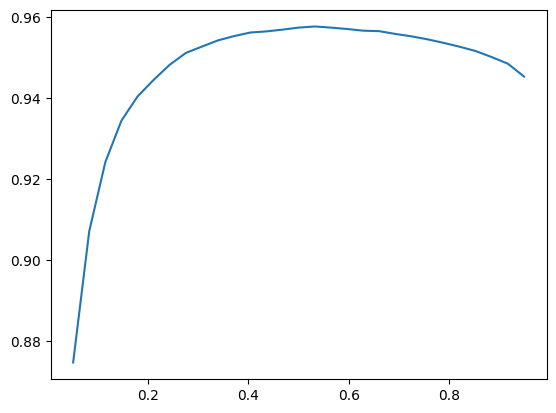

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)